# Lab 16 Assignment 3 - Group Assignment

When creating ML models, the concept of efficiency has three sides:
1. The time dedicated by the analyst to build the model
2. The computer time and resources needed by the final model
3. The accuracy of the final model

Efficiency is a combination of all

In this assignment, you are asked to be efficient. Spark is the best tool to build models over massive datasets

If you need to create Spark+Python Machine Learning models that "run fast" on the  cluster, you must avoid using Python code or working with RRD+python. Try to use  the already existing methods that do what you need (do not reinvent the wheel).

Therefore try to use the implemented object+methods inside the Spark SQL and ML modules. They are very fast, because it is compiled Java/Scala code. Try to use: DataFrames, Feature Transfomers, Estimators, Pipelines, GridSearch, CV, ...

For this assignment, you are asked to create a classification model that:
1. Uses the variables in the dataset (train.csv) to predict label "loan_status"
2. Write a python scripts that:
    - Reads the "train.csv" and "test.csv" files, transform and select variables as you wish.
    - Train/fit your model using the "train.csv".
    - Predict your model on the "test.csv" ( you should generate a file with your predictions).
    - I will use a different test dataset (with the true loan_status).

Your work will be evaluated under the following scoring schema
- (40%) ETL process
- (40%) Model train process
- (10%) Code Readability 
- (10%) AUC on the test set (at least 50%)

Enjoy it and best of luck!!


This Assignment is based on kaggle competition https://www.kaggle.com/c/loan-default-prediction from where a sub-dataset has been taken.

### File descriptions
**train.csv** - the training set (to use for building a model)

**test.csv** - the test set (to use for applying predictings)

**sample_submission.csv** - a template for the submission file

### Data Description (also contained in LendingClub_DataDescription.csv)
**ID**: A unique LC assigned ID for the loan listing.

**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**loan_status**: Current status of the loan (**Target**: 1 = Charged Off, 0 = Fully Paid).

**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

**int_rate**: Interest Rate on the loan.

**installment**: The monthly payment owed by the borrower if the loan originates.

**emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

**home_ownership**: The home ownership status provided by the borrower during registration. Our values are: OTHER/NONE, MORTGAGE, OWN, RENT.

**annual_inc**: The self-reported annual income provided by the borrower during registration.

**purpose**: A category provided by the borrower for the loan request.

**title**: The loan title provided by the borrower.

**STATE**: The state provided by the borrower in the loan application.

**delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

**revol_bal**: Total credit revolving balance.

**revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**total_pymnt**: Indicates total payment at the end of the loan.

In [5]:
import os
import sys

os.environ['SPARK_HOME'] = "C:\\spark-2.3.2-bin-hadoop2.7\\"

# Create a variable for our root path
SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path. Please check your installation
#to make sure that these zip files actually exist. The names might change
#as versions change.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.7-src.zip"))

#Initialize SparkSession and SparkContext
from pyspark.sql import SparkSession

#Create a Spark Session
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("MiPrimer") \
    .config("spark.executor.memory", "6g") \
    .config("spark.cores.max","4") \
    .getOrCreate()


#Get the Spark Context from Spark Session    
sc = spark.sparkContext

In [6]:
from pyspark.sql.functions import col
from pyspark.sql import functions as f
from pyspark.ml.feature import Imputer
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.ml.feature import Bucketizer
from pyspark.mllib.stat import Statistics
import pandas as pd

### 1. Read the files into a Dataframes and show them

In [7]:
loanDF = spark.read.format('csv') \
           .option("inferSchema", "true") \
           .option("header","true")\
           .option("delimiter", ";") \
           .load('../data/train.csv') 

testDF = spark.read.format('csv') \
            .option("inferSchema", "true") \
            .option("header","true")\
            .option("delimiter", ";") \
            .load('../data/test.csv') 

In [8]:
loanDF.limit(200).toPandas()

,ID,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,title,STATE,delinq_2yrs,revol_bal,revol_util,total_pymnt,loan_status
0,2,2500,60 months,15.27%,59.83,< 1 year,RENT,30000.00,car,bike,GA,0.0,1687.0,0.094,1014.530000,1
1,4,10000,36 months,13.49%,339.31,10+ years,RENT,49200.00,other,personel,CA,0.0,5598.0,0.21,12231.890000,0
2,5,3000,60 months,12.69%,67.79,1 year,RENT,80000.00,other,Personal,OR,0.0,27783.0,0.539,4066.908161,0
3,6,5000,36 months,7.90%,156.46,3 years,RENT,36000.00,wedding,My wedding loan I promise to pay back,AZ,0.0,7963.0,0.283,5632.210000,0
4,7,7000,60 months,15.96%,170.08,8 years,RENT,47004.00,debt_consolidation,Loan,NC,0.0,17726.0,0.856,10137.840010,0
5,8,3000,36 months,18.64%,109.43,9 years,RENT,48000.00,car,Car Downpayment,CA,0.0,8221.0,0.875,3939.135294,0
6,10,5375,60 months,12.69%,121.45,< 1 year,RENT,15000.00,other,Building my credit history.,TX,0.0,9279.0,0.365,1484.590000,1
7,11,6500,60 months,14.65%,153.45,5 years,OWN,72000.00,debt_consolidation,High intrest Consolidation,AZ,0.0,4032.0,0.206,7678.017673,0
8,12,12000,36 months,12.69%,402.54,10+ years,OWN,75000.00,debt_consolidation,Consolidation,CA,0.0,23336.0,0.671,13947.989160,0
9,14,3000,36 months,9.91%,96.68,3 years,RENT,15000.00,credit_card,citicard fund,IL,0.0,7323.0,0.431,3480.269999,0


In [9]:
loanDF.dtypes

loanDF=loanDF.withColumn('int_rate', col('int_rate').substr(1, 4))\
             .withColumn("int_rate", col("int_rate").cast('float'))\
             .withColumn('revol_util', col('revol_util').substr(1, 4))\
             .withColumn("revol_util", col("revol_util").cast('float'))\
             .withColumn("delinq_2yrs", col("delinq_2yrs").cast('float'))\
             .withColumn("revol_bal", col("revol_bal").cast('float'))

In [10]:
loanDF.toPandas().describe().round(decimals=0).transpose()

,count,mean,std,min,25%,50%,75%,max
ID,29755.0,19942.0,11462.0,2.0,10082.0,20009.0,29838.0,39759.0
loan_amnt,29755.0,11219.0,7432.0,500.0,5500.0,10000.0,15000.0,35000.0
int_rate,29755.0,12.0,4.0,5.0,9.0,12.0,14.0,24.0
installment,29755.0,324.0,208.0,16.0,167.0,281.0,429.0,1305.0
annual_inc,29755.0,69045.0,66683.0,4000.0,40800.0,59670.0,82600.0,6000000.0
delinq_2yrs,28516.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
revol_bal,28516.0,13351.0,15948.0,0.0,3704.0,8818.0,16978.0,149588.0
revol_util,27782.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
total_pymnt,28516.0,12144.0,9085.0,0.0,5565.0,9921.0,16498.0,58886.0
loan_status,29755.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2. Analizing null values, cross tables distribution and covariances

#### Analyzing missing and null values

In [11]:
loanDF_empty=loanDF.select([f.count(f.when(col(c).isNull() | f.isnan(c), c)).alias(c) for c in loanDF.columns])
print('Total number of rows = {0}. Total number of missing values, per column:'.format(loanDF.count()))
loanDF_empty.toPandas().transpose()

Total number of rows = 29755. Total number of missing values, per column:


,0
ID,0
loan_amnt,0
term,0
int_rate,0
installment,0
emp_length,0
home_ownership,0
annual_inc,0
purpose,1229
title,1238


In [12]:
#Missings treatment

empty_values=["delinq_2yrs","revol_bal","revol_util","total_pymnt"]
null_imputer=Imputer()\
        .setStrategy('median')\
        .setInputCols(empty_values)\
        .setOutputCols(empty_values)\
        .fit(loanDF)

loanDF=null_imputer.transform(loanDF)

#### Analyzing outliers

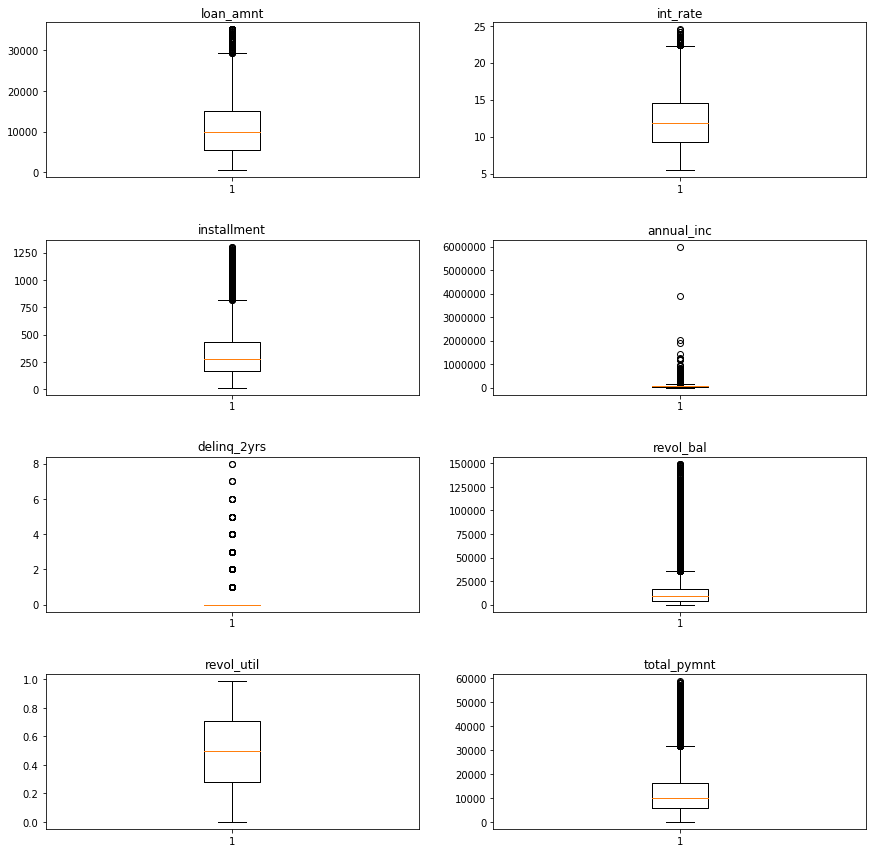

In [13]:
df=loanDF['loan_amnt','int_rate','installment','annual_inc','delinq_2yrs','revol_bal','revol_util','total_pymnt'].toPandas()
plt.subplots_adjust(hspace=0.4, wspace=0.2,left=0.1, right=2,top=2.9, bottom=0.1)
for i in range(0,8):
    plt.subplot(4,2,i+1)    
    plt.boxplot(df.iloc[:,i])
    plt.title(label=(df.columns[i]))

In [14]:
#Outlier treatment: Winsorization approach

#loan_amnt    
df=loanDF
val='loan_amnt'
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]
loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))

#int_rate
df=loanDF
val='int_rate'
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]
loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))

#installment
df=loanDF
val='installment'
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]
loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))

#installment
df=loanDF
val='installment'
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]
loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))

#revol_bal
df=loanDF
val='revol_bal'
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]
loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))

#total_pymnt
df=loanDF
val='total_pymnt'
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]
loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))

#annual_inc
df=loanDF
val="annual_inc"
quantiles = df.approxQuantile(val, [0.05,0.95],0.0)
lower_thres = quantiles[0]
upper_thres = quantiles[1]

loanDF = df.withColumn(val,when(df[val] >= upper_thres,upper_thres).otherwise(df[val]))
loanDF = df.withColumn(val,when(df[val] <= lower_thres,lower_thres).otherwise(df[val]))

#### Validating Outliers Treatment

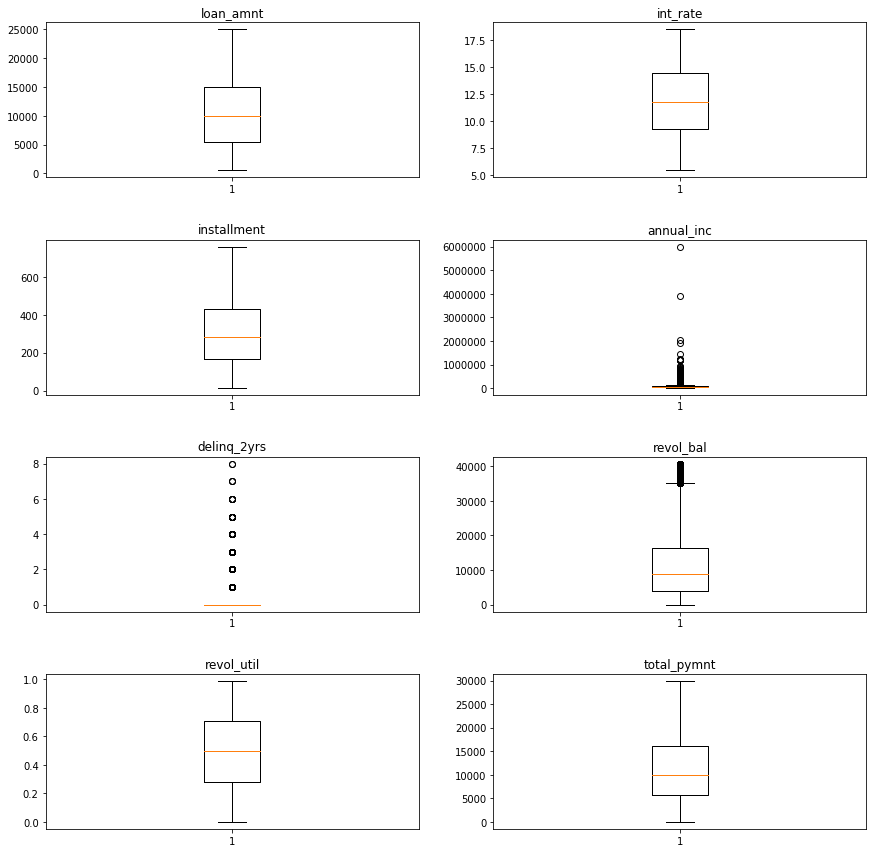

In [15]:
df=loanDF['loan_amnt','int_rate','installment','annual_inc','delinq_2yrs','revol_bal','revol_util','total_pymnt'].toPandas()
plt.subplots_adjust(hspace=0.4, wspace=0.2,left=0.1, right=2,top=2.9, bottom=0.1)
for i in range(0,8):
    plt.subplot(4,2,i+1)    
    plt.boxplot(df.iloc[:,i])
    plt.title(label=(df.columns[i]))

#### ETL summary

You should explain how you are going to clean and prepare the data

### 2.1 Spark code about the one explained in "ETL Summary"

### 2.2 Spark code about the transformations you apply to the variables

In [16]:
#Create new variable: ratio_installment/monthly_income

#r_ins_minc
loanDF=loanDF.withColumn('r_ins_minc',(loanDF['installment']/(loanDF['annual_inc']/12)))

In [17]:
#Numerical variables into categorical

#int_rate
val='int_rate'
splits=[-float("inf"),10.0,15.0,float("inf")]
bucketizer1=Bucketizer(splits=splits,inputCol=val,outputCol=val+'_disc')
loanDF=bucketizer1.transform(loanDF)

#delinq_2yrs
val='delinq_2yrs'
splits=[0.0,1.0,2.0,float("inf")]
bucketizer2=Bucketizer(splits=splits,inputCol=val,outputCol=val+'_disc')
loanDF=bucketizer2.transform(loanDF)

#r_ins_minc
val='r_ins_minc'
splits=[-float("inf"),0.05,0.1,float("inf")]
bucketizer3=Bucketizer(splits=splits,inputCol=val,outputCol=val+'_disc')
loanDF=bucketizer3.transform(loanDF)

#revol_util
val='revol_util'
splits=[-float("inf"),0.2,0.6,float("inf")]
bucketizer4=Bucketizer(splits=splits,inputCol=val,outputCol=val+'_disc')
loanDF=bucketizer4.transform(loanDF)

#revol_bal
val='revol_bal'
splits=[-float("inf"),10000,float("inf")]
bucketizer4=Bucketizer(splits=splits,inputCol=val,outputCol=val+'_disc')
loanDF=bucketizer4.transform(loanDF)

In [18]:
#Regrouping categorical variables

#term
df=loanDF
column='term'
loanDF = df.withColumn('term_g', (when(df[column] == ' 36 months', 0).otherwise(1)))

#purpose
df=loanDF
column='purpose'
loanDF = df.withColumn('purpose_g',\
            (when((df[column] == 'small_business') | (df[column] == 'renewable_energy'), 0)\
            .otherwise(when((df[column] == 'educational') | (df[column] == 'house') |(df[column] == 'moving')\
                            |(df[column] == 'other') |(df[column] == 'vacation') | (df[column] == 'debt_consolidation')\
                            | (df[column] == 'medical') | (df[column] == ''), 1).otherwise(2))))

#STATE
df=loanDF
column='STATE'
loanDF = df.withColumn('states_g',\
            (when((df[column] == 'NE') | (df[column] == 'NV') | (df[column] == 'AK'), 0)\
            .otherwise(when((df[column] == 'FL') | (df[column] == 'OR') |(df[column] == 'MO')\
                            |(df[column] == 'WA') |(df[column] == 'SD') | (df[column] == 'CA')\
                            | (df[column] == 'GA') | (df[column] == 'UT') | (df[column] == 'NJ'), 1)\
            .otherwise(when((df[column] == 'MD') | (df[column] == 'NC') |(df[column] == 'SC')\
                            |(df[column] == 'MN') |(df[column] == 'NI') | (df[column] == 'TN')\
                            | (df[column] == 'OH') | (df[column] == '') | (df[column] == 'KY')\
                            | (df[column] == 'WY') | (df[column] == 'NY') | (df[column] == 'OK')\
                            | (df[column] == 'AZ') | (df[column] == 'NM') | (df[column] == 'KS')\
                            | (df[column] == 'HI') | (df[column] == 'CT'), 2)\
            .otherwise(when((df[column] == 'IL') | (df[column] == 'VA') |(df[column] == 'VT')\
                            |(df[column] == 'AL') |(df[column] == 'MA') | (df[column] == 'RI')\
                            | (df[column] == 'CO') | (df[column] == 'TX') | (df[column] == 'MT')\
                            | (df[column] == 'WV') | (df[column] == 'PA') | (df[column] == 'NH')\
                            | (df[column] == 'AZ') | (df[column] == 'LA') | (df[column] == 'AR'),3)\
                            
            .otherwise(4))))))

In [19]:
#Drop variables no longer needed
loanDF = loanDF.drop('ID','term','loan_amnt','title','int_rate','installment','emp_length',\
                      'home_ownership','annual_inc','purpose','title','STATE','delinq_2yrs',\
                      'revol_bal','revol_util','total_pymnt','r_ins_minc')

#### Multivariate Analysis: Correlation Matrix

In [20]:
df = loanDF
col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,loan_status,int_rate_disc,delinq_2yrs_disc,r_ins_minc_disc,revol_util_disc,revol_bal_disc,term_g,purpose_g,states_g
loan_status,1.000000,0.184131,0.022667,0.072592,0.092285,0.020707,0.152397,-0.080596,-0.051108
int_rate_disc,0.184131,1.000000,0.146769,0.162067,0.393119,0.105700,0.423104,-0.107289,-0.012645
delinq_2yrs_disc,0.022667,0.146769,1.000000,-0.051068,-0.023686,-0.055947,0.003120,-0.028190,-0.023322
r_ins_minc_disc,0.072592,0.162067,-0.051068,1.000000,0.069082,0.103456,0.040366,-0.101793,0.010480
revol_util_disc,0.092285,0.393119,-0.023686,0.069082,1.000000,0.366907,0.064392,-0.075028,-0.054920
revol_bal_disc,0.020707,0.105700,-0.055947,0.103456,0.366907,1.000000,0.084737,-0.058928,-0.071330
term_g,0.152397,0.423104,0.003120,0.040366,0.064392,0.084737,1.000000,-0.023675,0.022959
purpose_g,-0.080596,-0.107289,-0.028190,-0.101793,-0.075028,-0.058928,-0.023675,1.000000,0.116971
states_g,-0.051108,-0.012645,-0.023322,0.010480,-0.054920,-0.071330,0.022959,0.116971,1.000000


In [21]:
#loanDF.dtypes

In [22]:
loanDF.toPandas().head(9)

,loan_status,int_rate_disc,delinq_2yrs_disc,r_ins_minc_disc,revol_util_disc,revol_bal_disc,term_g,purpose_g,states_g
0,1,2.0,0.0,0.0,0.0,0.0,1,2,1
1,0,1.0,0.0,1.0,1.0,0.0,0,1,1
2,0,1.0,0.0,0.0,1.0,1.0,1,1,1
3,0,0.0,0.0,1.0,1.0,0.0,0,2,2
4,0,2.0,0.0,0.0,2.0,1.0,1,1,2
5,0,2.0,0.0,0.0,2.0,0.0,0,2,1
6,1,1.0,0.0,1.0,1.0,0.0,1,1,3
7,0,1.0,0.0,0.0,1.0,0.0,1,1,2
8,0,1.0,0.0,1.0,2.0,1.0,0,1,1
9,0,0.0,0.0,0.0,1.0,0.0,0,2,3


### 2.3 Code to assemble the variables to a numerical vector (VectorAssembler)

In [23]:
from pyspark.ml.classification import LogisticRegression,LogisticRegressionSummary,RandomForestClassificationModel, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.param import Params
from pyspark.ml import Pipeline, PipelineModel

### 2.4 Create Pipeline for train and test data

In [24]:
stages = []
assembler = VectorAssembler(inputCols=["int_rate_disc","delinq_2yrs_disc","r_ins_minc_disc", "revol_util_disc",
                                "revol_bal_disc", "term_g", "purpose_g","states_g"], outputCol="features")
stages.append(assembler)

In [25]:
rf = RandomForestClassifier() \
        .setFeaturesCol("features") \
        .setLabelCol("loan_status") \
        .setSeed(100)
stages.append(rf)

pipeline = Pipeline(stages=stages)

In [26]:
evaluator = BinaryClassificationEvaluator() \
                .setLabelCol("loan_status") \
                .setRawPredictionCol("rawPrediction")

print("We are using metric: " + evaluator.getMetricName())

We are using metric: areaUnderROC


In [27]:
(trainingData, validationData) = loanDF.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(validationData.count())

20882
8873


In [38]:
trainingData.dtypes

[('loan_status', 'int'),
 ('int_rate_disc', 'double'),
 ('delinq_2yrs_disc', 'double'),
 ('r_ins_minc_disc', 'double'),
 ('revol_util_disc', 'double'),
 ('revol_bal_disc', 'double'),
 ('term_g', 'int'),
 ('purpose_g', 'int'),
 ('states_g', 'int')]

In [34]:
trainingData.toPandas().head(10)

,loan_status,int_rate_disc,delinq_2yrs_disc,r_ins_minc_disc,revol_util_disc,revol_bal_disc,term_g,purpose_g,states_g
0,0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,0,0.0,0.0,0.0,0.0,0.0,0,0,1
5,0,0.0,0.0,0.0,0.0,0.0,0,0,1
6,0,0.0,0.0,0.0,0.0,0.0,0,0,1
7,0,0.0,0.0,0.0,0.0,0.0,0,0,1
8,0,0.0,0.0,0.0,0.0,0.0,0,0,1
9,0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [37]:
validationData.toPandas().head(10)

,loan_status,int_rate_disc,delinq_2yrs_disc,r_ins_minc_disc,revol_util_disc,revol_bal_disc,term_g,purpose_g,states_g
0,0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,0,0.0,0.0,0.0,0.0,0.0,0,0,1
5,0,0.0,0.0,0.0,0.0,0.0,0,0,1
6,0,0.0,0.0,0.0,0.0,0.0,0,0,1
7,0,0.0,0.0,0.0,0.0,0.0,0,0,1
8,0,0.0,0.0,0.0,0.0,0.0,0,0,2
9,0,0.0,0.0,0.0,0.0,0.0,0,0,2


In [28]:
model = pipeline.fit(trainingData)
#model.explainParams()
pipeline_results = model.transform(validationData)

#pipeline_results.toPandas()

#pipeline_results.select('prediction').distinct().show()

In [41]:
trainingData.dtypes

[('loan_status', 'int'),
 ('int_rate_disc', 'double'),
 ('delinq_2yrs_disc', 'double'),
 ('r_ins_minc_disc', 'double'),
 ('revol_util_disc', 'double'),
 ('revol_bal_disc', 'double'),
 ('term_g', 'int'),
 ('purpose_g', 'int'),
 ('states_g', 'int')]

In [32]:
pipeline_results.select(col('prediction')).distinct().toPandas()

,prediction
0,0.0


In [110]:
print("AUC: " + str(evaluator.evaluate(pipeline_results)))

print();print('Model Parameters')
print('----------------')
print(rf.extractParamMap())

AUC: 0.6773291555841279

Model Parameters
----------------
{Param(parent='RandomForestClassifier_4e55a3fe26a12af2574f', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability', Param(parent='RandomForestClassifier_4e55a3fe26a12af2574f', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction', Param(parent='RandomForestClassifier_4e55a3fe26a12af2574f', name='seed', doc='random seed.'): 100, Param(parent='RandomForestClassifier_4e55a3fe26a12af2574f', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='RandomForestClassifier_4e55a3fe26a12af2574f', name='labelCol', doc='label column name.'): 'loan_status', Param(parent='RandomForestClassifier_4e55a3fe26a12af2574f', name='featuresCol', doc='features column name.'): 'features', P

### 3. Logistic Regresion Model

### 3.1 Write a function "metrics" which has a LogisticRegressionModel.summary as input attribute and produces an output of: 
1. Area under ROC
2. False Positive Rate By Label
3. True Positive Rate By Label
4. Precision By Label
5. Recall By Label
6. fMeasure By Label
7. Accuracy
8. False Positive Rate
9. True Positive Rate
10. fMeasure
11. Precision
12. Recall

In [ ]:
def metrics(trainingSummary):
    
    
    
    

### 3.2 Apply a Logistic Regresion Base Model and show the metrics by the function above

### 3.2 We are going to try to improve our model:
1. Using a `weight column` in our Logistic Regression Model (Take into account we are working with a unbalanced dataset)
2. Define a `ParamGridBuilder` with `regParam`, `elasticNetParam` and `maxIter` at least
3. Define an `BinaryClassificationEvaluator`
4. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:
1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which are the metrics of the best model (training) in the 5 k-fold runs? (Use the function above)
5. Which is the ROC-AUC on validation dataset?


### 4. Random Forest Model
1. Define a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

### 5. Gradient Boosting Model
1. Defining a `ParamGridBuilder` with `maxDepth`, `numTrees` and `maxIter` at least (You can use the above one)
2. Define an `BinaryClassificationEvaluator` (You can use the above one)
3. Using Cross Validation with a 5-fold `CrossValidator`

Questions to answer:

1. Have we improved the ROC-AUC?
2. Which are the average ROC-AUC measurements in the different cross validation runs?
3. Which are the parameters of the best model in the 5 k-fold runs?
4. Which is the importance of the features?
5. Print full description of model.
6. Which is the ROC-AUC on validation dataset?

### 6. Apply your best model to send the predictions on test

In [155]:
sc.stop()